In [1]:
%load_ext autoreload

import os
import sys
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_object_dtype

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

root_dir = os.path.abspath('..')
sys.path.append(os.path.join(root_dir, 'src/'))

import feature_preprocess
import eda_functions
import baseline

In [2]:
DATA_FOLDER = os.path.join(root_dir, 'data/')
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
SEGMENTS_FILE = 'Segments.xlsx'
CITIES_FILE = 'data_cities.csv'
RANDOM_STATE = 27

FRAC = 0.05

pd.set_option('display.max_columns', None)

In [3]:
def preprocess_text_features(df, text_features=None, os_version='osv'):
    
    df = df.copy()
    if text_features is None:
        text_features = ['gamecategory', 'subgamecategory', 'bundle', 'oblast', 'city', 'os']

    for ftr in text_features:
        df[ftr] = df[ftr].str.upper()
    df[os_version] = df[os_version].str.replace(r'[^0-9]', '', regex=True)
    df[os_version] = df[os_version].str.rstrip('0')

    return df

# Загрузка данных

In [4]:
segments = pd.read_excel(os.path.join(DATA_FOLDER, SEGMENTS_FILE))
display(segments)

,Номер сегмента,Возраст,Пол,Интересы
0,1,"25-34,35-41",Ж,-
1,2,"25-34,35-42",М,Пиво
2,3,"25-34,35-43",Ж,Дети
3,4,"18-24,25-34,35-44","М, Ж",Животные
4,5,"18-24,25-34,35-45","М, Ж",-


In [5]:
train_raw = pd.read_csv(os.path.join(DATA_FOLDER, TRAIN_FILE))
display(train_raw.head())
print(train_raw.shape)

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv
0,4,Games,Racing,com.MadOut.BIG,2021-07-05 18:07:40,MSK+6,Забайкальский Край,Чита,android,10.0
1,4,NaN,NaN,com.easybrain.solitaire.klondike.free,2021-07-10 10:38:42,MSK+2,Оренбургская область,Оренбург,Android,10.0.0
2,5,Games,Arcade,com.orbitalknight.ridiculousfreekick,2021-08-04 13:34:29,MSK,Санкт-Петербург,Санкт-Петербург,android,9.0
3,5,NaN,NaN,tcouchgind.scooterextreme.scooter,2021-08-06 07:35:27,MSK+2,Свердловская область,Екатеринбург,android,9
4,4,NaN,NaN,com.FidgetTrading3D.game,2021-08-02 20:43:59,MSK,Московская область,Звенигород,android,6.0.1


(44854516, 10)


In [6]:
_, train_raw_frac = train_test_split(train_raw, test_size=FRAC, random_state=RANDOM_STATE, stratify=train_raw['Segment'])

In [7]:
train_raw_frac = preprocess_text_features(train_raw_frac)

In [8]:
del train_raw

In [9]:
# test_raw = pd.read_csv(os.path.join(DATA_FOLDER, TEST_FILE))
# display(test_raw.head())
# print(test_raw.shape)

In [10]:
def prepare_X_y(data, target, prefix='Segment', drop_duplicates=False):
    data = data.copy()

    if drop_duplicates:
        data.drop_duplicates(inplace=True)
    
    targets_df = pd.get_dummies(data[target], prefix=prefix)

    X = data.drop(columns=target)

    return X, targets_df

In [11]:
def train_model(pars, X_t, y_t, X_v, y_v, eval_metric):

    model = lightgbm.LGBMClassifier(**pars)
    model.fit(X_t, y_t, eval_metric=eval_metric, eval_set=(X_v, y_v))

    return model

def validate_model(model, X_t, y_t, X_v, y_v):

    print('model')
    print('Train roc auc', metrics.roc_auc_score(y_t, model.predict_proba(X_t).T[1]))
    print('Validation roc auc', metrics.roc_auc_score(y_v, model.predict_proba(X_v).T[1]))

    print(metrics.classification_report(y_v, model.predict(X_v)))

    eda_functions.plot_confusion_matrix(y_v, model.predict(X_v))

In [12]:
def check_roc_auc(y_true, y_pred_proba):
    for true, pred_proba in zip(y_true, y_pred_proba):
        print(true.name)
        print(metrics.roc_auc_score(true, pred_proba))

# Подготовка обучающего датасета

In [13]:
train_raw_time_ftrs = \
feature_preprocess.make_features_from_time(
    train_raw_frac,
    dt_target='loc',
    datetime_col_msk='created',
    shift_col = 'shift',
    fill_shift_na=False,
    shift_filler='MSK',
    dt_format = '%Y-%m-%d %H:%M:%S'
    )

tags_cols = [
    'weekday',
    'is_weekend',
    'is_academic_year',
    'is_early_morning',
    'is_morning',
    'is_day',
    'is_evening',
    'is_late_evening',
    'is_night'
]

train_raw_time_ftrs = feature_preprocess.get_tags_from_time_features(
    train_raw_time_ftrs, 
    tags_cols=tags_cols, 
    tags_dict=None)

In [14]:
train_raw_all_ftrs = train_raw_frac.join(train_raw_time_ftrs)
train_raw_all_ftrs.drop(columns=['created', 'shift'], inplace=True)

In [15]:
del train_raw_time_ftrs

In [16]:
train_raw_all_ftrs['subgamecategory'], mode_sub = \
    feature_preprocess.impute_column(train_raw_all_ftrs, 'subgamecategory')

train_raw_all_ftrs['gamecategory'], mode_game = \
    feature_preprocess.impute_column(train_raw_all_ftrs, 'gamecategory')

In [17]:
display(train_raw_all_ftrs.head())

,Segment,gamecategory,subgamecategory,bundle,oblast,city,os,osv,loc_weekday_tag,loc_is_weekend_tag,loc_is_academic_year_tag,loc_time_of_day_tag
34276311,5,NaN,NaN,COM.REDANTZ.GAME.STICKWARS2,АРХАНГЕЛЬСКАЯ ОБЛАСТЬ,СЕВЕРОДВИНСК,ANDROID,712,среда,рабочий_день,каникулы,утро
3572342,3,NaN,NaN,1016489154,МОСКВА,МОСКВА,IOS,1471,суббота,выходной,каникулы,день
28510426,3,NaN,NaN,COM.NEXTERS.HEROWARS,МОСКВА,МОСКВА,ANDROID,11,понедельник,рабочий_день,каникулы,вечер
1689867,4,GAMES,MUSIC,COM.YOURSTORYINTERACTIVE.SAILS.PIRATE.ADVENTURE,САМАРСКАЯ ОБЛАСТЬ,САМАРА,ANDROID,1,понедельник,рабочий_день,каникулы,день
2438283,4,NaN,NaN,COM.IPOSEDON.BRICKSBREAKERBALLS,ТАТАРСТАН,КАЗАНЬ,ANDROID,1,понедельник,рабочий_день,каникулы,утро


In [18]:
train,  valid_test = train_test_split(train_raw_all_ftrs, test_size=0.3, random_state=RANDOM_STATE, stratify=train_raw_all_ftrs['Segment'])
valid, test = train_test_split(valid_test, test_size=0.5, random_state=RANDOM_STATE, stratify=valid_test['Segment'])

In [19]:
del valid_test

In [20]:
display(train.head())

,Segment,gamecategory,subgamecategory,bundle,oblast,city,os,osv,loc_weekday_tag,loc_is_weekend_tag,loc_is_academic_year_tag,loc_time_of_day_tag
43727045,1,NaN,NaN,COM.COMPUTERLUNCH.EVOLUTION,САНКТ-ПЕТЕРБУРГ,САНКТ-ПЕТЕРБУРГ,ANDROID,81,среда,рабочий_день,каникулы,вечер
5328182,4,NaN,NaN,COM.IPOSEDON.BRICKSBREAKERBALLS,АЛТАЙСКИЙ КРАЙ,БИЙСК,ANDROID,1,понедельник,рабочий_день,каникулы,утро
31685436,3,NaN,NaN,COM.CREATIVEJOY.RU.JEWELANCIENTTEMPLE,АСТРАХАНСКАЯ ОБЛАСТЬ,АСТРАХАНЬ,ANDROID,601,воскресенье,выходной,каникулы,раннее_утро
35223798,5,NaN,NaN,COM.AWARDSMEDIAGROUP.TANKS,АСТРАХАНСКАЯ ОБЛАСТЬ,АСТРАХАНЬ,ANDROID,9,понедельник,рабочий_день,каникулы,день
10550958,5,NaN,NaN,ZOMBIE.SURVIVAL.CRAFT.Z,САНКТ-ПЕТЕРБУРГ,САНКТ-ПЕТЕРБУРГ,ANDROID,1,вторник,рабочий_день,каникулы,день


In [176]:
train_new = train.copy()
    
train_new = train_new.fillna('')

train_new['os_with_version'] = train_new['os'] + '_' + train_new['osv']
train_new.drop(columns=['os', 'osv'], inplace=True)

train_new['bundle'] = train_new['bundle'].apply(lambda x: ' '.join(str(x).split('.')))

train_new['description'] = ''

for i in range(1, len(train_new.columns)):
    train_new['description'] += ' ' + train_new.iloc[:,i]

train_new['description'] = train_new['description'].str.strip()

In [61]:
# def create_idf(company_list):

#     num_doc_with_word = {}
#     idf_dict = {}
#     num_doc  = len(company_list)
    
#     for company in company_list.astype('str'):
#         for word in list( set(company.split()) ):
#             if word not in num_doc_with_word.keys():
#                 num_doc_with_word[word] = 1
#             else:
#                 num_doc_with_word[word] += 1
    
#     for word in num_doc_with_word:
#         idf_dict[word] = np.log(num_doc / num_doc_with_word[word])
#     return idf_dict
    

# def calc_internal_idfs(parents_series, names_sets_series):
#     internal_idf_dict = {}
#     parents_list = parents_series.to_list()
#     names_sets_list = names_sets_series.to_list()
#     for parent, names_set in zip(parents_list, names_sets_list):
#         names_list = list(names_set)
#         n_texts = len(names_list)
#         idfs = {}
#         for name in names_list:
#             for word in name.split():
#                 if word in idfs:
#                     idfs[word] += 1
#                 else:
#                     idfs[word] = 1
#         for word in idfs:
#             idfs[word] = idfs[word] / n_texts
        
#         internal_idf_dict[parent] = idfs
    
#     return internal_idf_dict


# def calc_external_idfs(names_sets_series):
#     names_sets_list = names_sets_series.to_list()
#     n_texts = names_sets_series.shape[0]
#     all_words_list = []
#     for names_set in names_sets_list:
#         names_list = list(names_set)
        
#         names_splited_list = [name.split() for name in names_list]
#         words_list = list(set([item for sublist in names_splited_list for item in sublist]))
#         all_words_list = all_words_list + words_list
    
#     external_idf_dict = {}
#     for word in all_words_list:
#         if word in external_idf_dict:
#             external_idf_dict[word] += 1
#         else:
#             external_idf_dict[word] = 1
#         external_idf_dict[word] = external_idf_dict[word] / n_texts

#     return external_idf_dict


# def get_words_quality(internal_idf_dict, external_idf_dict, idfs, parent):

#     words_quality_dict = {}
#     # for parent in internal_idf_dict:
#     for word in internal_idf_dict[parent]:
#         words_quality_dict[word] = internal_idf_dict[parent][word] / external_idf_dict[word]

#     word_quality_df = pd.DataFrame.from_dict(words_quality_dict, orient='index', columns=['word_quality']).reset_index()
#     word_quality_df = word_quality_df.rename(columns={'index': 'Word'})
#     word_quality_df.loc[:, 'word_quality'] = np.log(word_quality_df['word_quality'])


#     word_quality_df = word_quality_df.merge(idfs, on='Word')
#     word_quality_df.loc[:, 'word_idf_quality'] = word_quality_df['word_quality'] * word_quality_df['idf']
#     word_quality_df = word_quality_df.sort_values(by='word_quality', ascending=False)

#     return word_quality_df

In [177]:
def create_idf(company_list):

    num_doc_with_word = {}
    idf_dict = {}
    num_doc  = len(company_list)
    
    for company in company_list.astype('str'):
        for word in list( set(company.split()) ):
            if word not in num_doc_with_word.keys():
                num_doc_with_word[word] = 1
            else:
                num_doc_with_word[word] += 1
    
    for word in num_doc_with_word:
        idf_dict[word] = np.log(num_doc / num_doc_with_word[word])
    return idf_dict
    

def calc_internal_idfs(parents_series, names_sets_series):
    internal_idf_dict = {}
    parents_list = parents_series.to_list()
    names_sets_list = names_sets_series.to_list()
    for parent, names_set in zip(parents_list, names_sets_list):
        names_list = list(names_set)
        n_texts = len(names_list)
        idfs = {}
        for name in names_list:
            for word in name.split():
                if word in idfs:
                    idfs[word] += 1
                else:
                    idfs[word] = 1
        for word in idfs:
            idfs[word] = idfs[word] / n_texts
        
        internal_idf_dict[parent] = idfs
    
    return internal_idf_dict


def calc_external_idfs(names_sets_series):
    names_sets_list = names_sets_series.to_list()
    n_texts = names_sets_series.shape[0]
    all_words_list = []
    for names_set in names_sets_list:
        names_list = list(names_set)
        
        names_splited_list = [name.split() for name in names_list]
        words_list = list(set([item for sublist in names_splited_list for item in sublist]))
        all_words_list = all_words_list + words_list
    
    external_idf_dict = {}
    for word in all_words_list:
        if word in external_idf_dict:
            external_idf_dict[word] += 1
        else:
            external_idf_dict[word] = 1
        external_idf_dict[word] = external_idf_dict[word] / n_texts

    return external_idf_dict


def get_words_quality(internal_idf_dict, external_idf_dict, idfs, parent):

    words_quality_dict = {}
    # for parent in internal_idf_dict:
    for word in internal_idf_dict[parent]:
        words_quality_dict[word] = internal_idf_dict[parent][word] / external_idf_dict[word]

    word_quality_df = pd.DataFrame.from_dict(words_quality_dict, orient='index', columns=['word_quality']).reset_index()
    word_quality_df = word_quality_df.rename(columns={'index': 'Word'})
    word_quality_df.loc[:, 'word_quality'] = np.log(word_quality_df['word_quality'])


    word_quality_df = word_quality_df.merge(idfs, on='Word')
    word_quality_df.loc[:, 'word_idf_quality'] = word_quality_df['word_quality'] * word_quality_df['idf']
    word_quality_df = word_quality_df.sort_values(by='word_quality', ascending=False)

    return word_quality_df

In [31]:
# idfs = create_idf(train_new['description'])
# idfs_df = pd.DataFrame.from_dict(idfs, orient='index').reset_index()
# idfs_df.columns = ['Word', 'idf']
# idfs_df.to_csv(os.path.join(DATA_FOLDER ,'idfs.csv'), index=False)

In [178]:
idfs = pd.read_csv(os.path.join(DATA_FOLDER, 'idfs.csv'), keep_default_na=False)

In [179]:
train_new_prepared = train_new[['Segment', 'description']].groupby('Segment').agg(set).reset_index()

In [180]:
internal_idf_dict = calc_internal_idfs(train_new_prepared['Segment'], train_new_prepared['description'])
external_idf_dict = calc_external_idfs(train_new_prepared['description'])

In [46]:
segments = train_new_prepared['Segment'].to_list()

In [62]:
words_quality_df = {}
for s in segments:
    words_quality_df[s] = get_words_quality(internal_idf_dict, external_idf_dict, idfs, s)

In [70]:
# set_ = {}
# set_[1] = set(words_quality_df[1].head(10)['Word'])
# set_[2] = set(words_quality_df[2].head(10)['Word'])
# set_[3] = set(words_quality_df[3].head(10)['Word'])
# set_[4] = set(words_quality_df[4].head(10)['Word'])
# set_[5] = set(words_quality_df[5].head(10)['Word'])

In [71]:
# common = set_[1] & set_[2] & set_[3] & set_[4] & set_[5]

In [74]:
# for s in segments:
#     display(words_quality_df[s][~words_quality_df[s]['Word'].isin(common).head(10))

,Word,word_quality,idf,word_idf_quality
8,каникулы,1.753432,0.487662,0.855083
16,учебный_год,0.562655,1.185282,0.666905
28,выходной,0.547435,1.493886,0.817806
57,понедельник,0.389880,1.736381,0.676979
37,ANDROID_9,0.361725,1.779828,0.643807
9,вечер,0.326463,2.062818,0.673434
18,ANDROID_11,0.158512,1.816991,0.288016
6,среда,0.145836,1.852226,0.270122
52,КРАЙ,0.100901,1.985644,0.200354
20,четверг,0.090718,2.146541,0.194731


,Word,word_quality,idf,word_idf_quality
12,учебный_год,2.024132,1.185282,2.399168
11,выходной,1.158047,1.493886,1.729991
62,утро,0.867665,1.795076,1.557525
14,ANDROID_11,0.574711,1.816991,1.044246
10,суббота,0.565203,2.141459,1.210359
51,пятница,0.482608,2.093665,1.010419
35,понедельник,0.442402,1.736381,0.768178
56,воскресенье,0.353404,2.234785,0.789781
46,ANDROID_9,0.322534,1.779828,0.574055
43,КРАЙ,0.197535,1.985644,0.392234


,Word,word_quality,idf,word_idf_quality
17,каникулы,1.688051,0.487662,0.823199
33,выходной,0.964686,1.493886,1.441131
8,учебный_год,0.846193,1.185282,1.002978
39,вечер,0.360184,2.062818,0.742994
82,воскресенье,0.297564,2.234785,0.664991
32,суббота,0.244818,2.141459,0.524268
88,пятница,0.237274,2.093665,0.496772
9,утро,0.198922,1.795076,0.357080
101,ANDROID_9,0.194549,1.779828,0.346264
144,ANDROID_11,0.139487,1.816991,0.253447


,Word,word_quality,idf,word_idf_quality
6,каникулы,1.856505,0.487662,0.905347
36,понедельник,0.616459,1.736381,1.070407
25,ANDROID_9,0.426758,1.779828,0.759555
23,выходной,0.367045,1.493886,0.548324
70,вечер,0.326347,2.062818,0.673193
49,учебный_год,0.287211,1.185282,0.340426
16,ANDROID_11,0.232742,1.816991,0.422890
14,вторник,0.224555,2.103284,0.472303
37,утро,0.198125,1.795076,0.355649
15,поздний_вечер,0.151276,2.373701,0.359085


,Word,word_quality,idf,word_idf_quality
8,каникулы,1.435782,0.487662,0.700177
15,учебный_год,1.262144,1.185282,1.495997
20,утро,0.516419,1.795076,0.927011
13,среда,0.506552,1.852226,0.938249
7,выходной,0.487738,1.493886,0.728625
63,понедельник,0.414638,1.736381,0.719969
46,ANDROID_11,0.310599,1.816991,0.564355
24,ANDROID_9,0.251413,1.779828,0.447472
4,КРАЙ,0.250105,1.985644,0.496620
23,вторник,0.133189,2.103284,0.280134


In [76]:
# all_qualities = []
# for s in segments:
#     all_qualities += words_quality_df[s]['word_quality'].to_list()

In [75]:
# plt.figure(figsize=(10,5)
# plt.hist(all_qualities, bins=100)
# plt.show()

In [77]:
X_train, y_train = prepare_X_y(train, 'Segment', prefix='Segment', drop_duplicates=True)
X_valid, y_valid = prepare_X_y(valid, 'Segment', prefix='Segment', drop_duplicates=False)
X_test, y_test = prepare_X_y(test, 'Segment', prefix='Segment', drop_duplicates=False)

train
5    601563
3    496547
4    389973
2     49568
1     32257
Name: Segment, dtype: int64


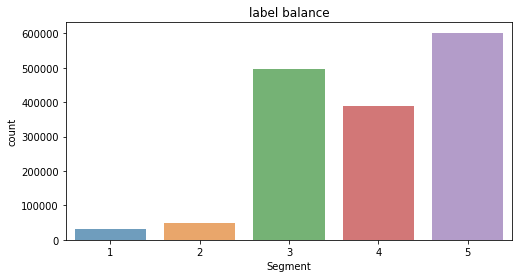

validation
5    128906
3    106403
4     83565
2     10622
1      6913
Name: Segment, dtype: int64


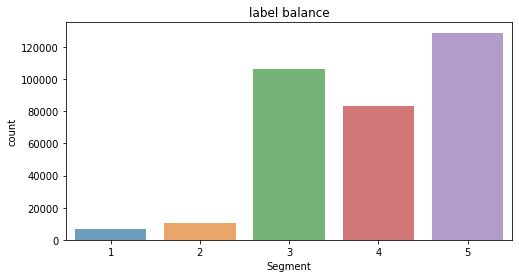

test
5    128906
3    106403
4     83566
2     10622
1      6912
Name: Segment, dtype: int64


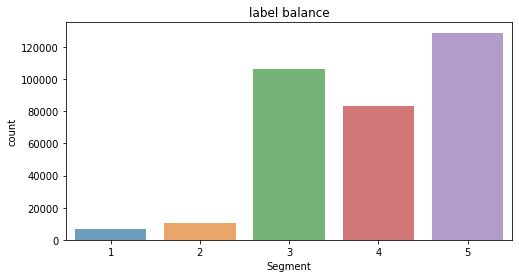

In [78]:
for d, name in zip([train, valid, test], ['train', 'validation', 'test']):
    print(name)
    eda_functions.show_label_balance(d, label='Segment')

In [79]:
# del train
# del valid
# del test

# Обучение моделей

In [80]:
target_names = [col for col in y_train.columns]
category_cols = X_train.columns
print(target_names)
print(category_cols)

['Segment_1', 'Segment_2', 'Segment_3', 'Segment_4', 'Segment_5']
Index(['gamecategory', 'subgamecategory', 'bundle', 'oblast', 'city', 'os',
       'osv', 'loc_weekday_tag', 'loc_is_weekend_tag',
       'loc_is_academic_year_tag', 'loc_time_of_day_tag'],
      dtype='object')


In [113]:
pars = {}
models = {}
eval_metric='auc'
TRAIN_FRAC = 1

In [89]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [173]:
pars['Segment_1'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.1,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 5,
}

pars['Segment_2'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.15,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 5,
}

pars['Segment_3'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.3,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 5,
}

pars['Segment_4'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.3,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 5,
}

pars['Segment_5'] = {
    'verbose': -1,
    'num_leaves': 31,
    'n_estimators':  300,
    'learning_rate': 0.3,
    'metric': 'f1',
    'class_weight': 'balanced',
    'early_stopping_round': 5,
}

targ = 'Segment_1'

models[targ] = train_model(pars[targ], X_train, y_train[targ], X_valid, y_valid[targ], eval_metric)

/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.680129
[2]	valid_0's auc: 0.686449
[3]	valid_0's auc: 0.690884
[4]	valid_0's auc: 0.714702
[5]	valid_0's auc: 0.723984
[6]	valid_0's auc: 0.727265
[7]	valid_0's auc: 0.731952
[8]	valid_0's auc: 0.734707
[9]	valid_0's auc: 0.736756
[10]	valid_0's auc: 0.737347
[11]	valid_0's auc: 0.739078
[12]	valid_0's auc: 0.740149
[13]	valid_0's auc: 0.741269
[14]	valid_0's auc: 0.742269
[15]	valid_0's auc: 0.742033
[16]	valid_0's auc: 0.742213
[17]	valid_0's auc: 0.742792
[18]	valid_0's auc: 0.742433
[19]	valid_0's auc: 0.743208
[20]	valid_0's auc: 0.743394
[21]	valid_0's auc: 0.743774
[22]	valid_0's auc: 0.743316
[23]	valid_0's auc: 0.743159
[24]	valid_0's auc: 0.743149
[25]	valid_0's auc: 0.743072
[26]	valid_0's auc: 0.742973


model
Train roc auc 0.8124870858914516
Validation roc auc 0.7437735450488667
              precision    recall  f1-score   support

           0       0.99      0.64      0.78    329496
           1       0.04      0.71      0.07      6913

    accuracy                           0.64    336409
   macro avg       0.52      0.67      0.43    336409
weighted avg       0.97      0.64      0.76    336409



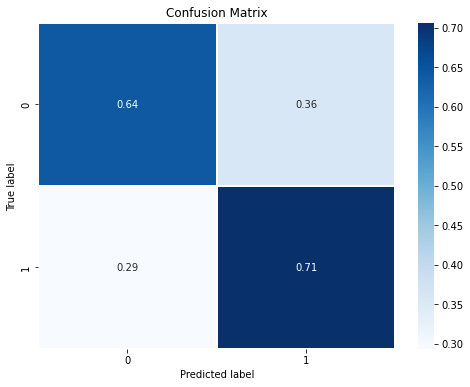

In [174]:
validate_model(models[targ], X_train, y_train[targ], X_valid, y_valid[targ])

In [ ]:
# pars['Segment_2'] = {
#     'verbose': -1,
#     'num_leaves': 31,
#     'n_estimators':  300,
#     'learning_rate': 0.1,
#     'metric': 'f1',
#     'class_weight': 'balanced',
#     'early_stopping_round': 10,
# }

# pars['Segment_3'] = {
#     'verbose': -1,
#     'num_leaves': 31,
#     'n_estimators':  300,
#     'learning_rate': 0.1,
#     'metric': 'f1',
#     'class_weight': 'balanced',
#     'early_stopping_round': 10,
# }

# pars['Segment_4'] = {
#     'verbose': -1,
#     'num_leaves': 31,
#     'n_estimators':  300,
#     'learning_rate': 0.1,
#     'metric': 'f1',
#     'class_weight': 'balanced',
#     'early_stopping_round': 10,
# }

# pars['Segment_5'] = {
#     'verbose': -1,
#     'num_leaves': 31,
#     'n_estimators':  300,
#     'learning_rate': 0.1,
#     'metric': 'f1',
#     'class_weight': 'balanced',
#     'early_stopping_round': 10,
# }

In [83]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

In [84]:
for targ in target_names:
    models[targ] = train_model(pars[targ], X_train, y_train[targ], X_valid, y_valid[targ], eval_metric)

/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.680129
[2]	valid_0's auc: 0.686449
[3]	valid_0's auc: 0.690884
[4]	valid_0's auc: 0.714702
[5]	valid_0's auc: 0.723984
[6]	valid_0's auc: 0.727265
[7]	valid_0's auc: 0.731952
[8]	valid_0's auc: 0.734707
[9]	valid_0's auc: 0.736756
[10]	valid_0's auc: 0.737347
[11]	valid_0's auc: 0.739078
[12]	valid_0's auc: 0.740149
[13]	valid_0's auc: 0.741269
[14]	valid_0's auc: 0.742269
[15]	valid_0's auc: 0.742033
[16]	valid_0's auc: 0.742213
[17]	valid_0's auc: 0.742792
[18]	valid_0's auc: 0.742433
[19]	valid_0's auc: 0.743208
[20]	valid_0's auc: 0.743394
[21]	valid_0's auc: 0.743774
[22]	valid_0's auc: 0.743316
[23]	valid_0's auc: 0.743159
[24]	valid_0's auc: 0.743149
[25]	valid_0's auc: 0.743072
[26]	valid_0's auc: 0.742973
[27]	valid_0's auc: 0.742688
[28]	valid_0's auc: 0.742355
[29]	valid_0's auc: 0.742411
[30]	valid_0's auc: 0.743145
[31]	valid_0's auc: 0.743423


/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.921422
[2]	valid_0's auc: 0.923677
[3]	valid_0's auc: 0.924856
[4]	valid_0's auc: 0.925206
[5]	valid_0's auc: 0.926192
[6]	valid_0's auc: 0.926403
[7]	valid_0's auc: 0.926406
[8]	valid_0's auc: 0.926389
[9]	valid_0's auc: 0.926819
[10]	valid_0's auc: 0.927227
[11]	valid_0's auc: 0.92748
[12]	valid_0's auc: 0.927535
[13]	valid_0's auc: 0.928562
[14]	valid_0's auc: 0.92905
[15]	valid_0's auc: 0.929195
[16]	valid_0's auc: 0.929226
[17]	valid_0's auc: 0.929334
[18]	valid_0's auc: 0.92957
[19]	valid_0's auc: 0.929708
[20]	valid_0's auc: 0.929889
[21]	valid_0's auc: 0.930478
[22]	valid_0's auc: 0.930134
[23]	valid_0's auc: 0.930718
[24]	valid_0's auc: 0.931121
[25]	valid_0's auc: 0.931483
[26]	valid_0's auc: 0.931527
[27]	valid_0's auc: 0.931712
[28]	valid_0's auc: 0.931761
[29]	valid_0's auc: 0.93185
[30]	valid_0's auc: 0.931885
[31]	valid_0's auc: 0.931891
[32]	valid_0's auc: 0.931953
[33]	valid_0's auc: 0.931939
[34]	valid_0's auc: 0.931879
[35]	valid_0's auc: 0.93200

/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.734983
[2]	valid_0's auc: 0.738699
[3]	valid_0's auc: 0.741382
[4]	valid_0's auc: 0.743632
[5]	valid_0's auc: 0.745359
[6]	valid_0's auc: 0.745923
[7]	valid_0's auc: 0.747694
[8]	valid_0's auc: 0.748569
[9]	valid_0's auc: 0.749599
[10]	valid_0's auc: 0.750544
[11]	valid_0's auc: 0.753184
[12]	valid_0's auc: 0.753956
[13]	valid_0's auc: 0.754989
[14]	valid_0's auc: 0.755794
[15]	valid_0's auc: 0.756811
[16]	valid_0's auc: 0.757573
[17]	valid_0's auc: 0.758747
[18]	valid_0's auc: 0.759606
[19]	valid_0's auc: 0.760303
[20]	valid_0's auc: 0.760976
[21]	valid_0's auc: 0.761523
[22]	valid_0's auc: 0.761845
[23]	valid_0's auc: 0.762717
[24]	valid_0's auc: 0.763341
[25]	valid_0's auc: 0.764048
[26]	valid_0's auc: 0.764713
[27]	valid_0's auc: 0.765341
[28]	valid_0's auc: 0.765806
[29]	valid_0's auc: 0.766107
[30]	valid_0's auc: 0.766443
[31]	valid_0's auc: 0.766814
[32]	valid_0's auc: 0.766968
[33]	valid_0's auc: 0.767239
[34]	valid_0's auc: 0.767555
[35]	valid_0's auc: 0.7

/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.75158
[2]	valid_0's auc: 0.75303
[3]	valid_0's auc: 0.757894
[4]	valid_0's auc: 0.760482
[5]	valid_0's auc: 0.761456
[6]	valid_0's auc: 0.763035
[7]	valid_0's auc: 0.766697
[8]	valid_0's auc: 0.767229
[9]	valid_0's auc: 0.767703
[10]	valid_0's auc: 0.76872
[11]	valid_0's auc: 0.769221
[12]	valid_0's auc: 0.769941
[13]	valid_0's auc: 0.770651
[14]	valid_0's auc: 0.770565
[15]	valid_0's auc: 0.770843
[16]	valid_0's auc: 0.771172
[17]	valid_0's auc: 0.771755
[18]	valid_0's auc: 0.772109
[19]	valid_0's auc: 0.773339
[20]	valid_0's auc: 0.775964
[21]	valid_0's auc: 0.777156
[22]	valid_0's auc: 0.777379
[23]	valid_0's auc: 0.777804
[24]	valid_0's auc: 0.778605
[25]	valid_0's auc: 0.779471
[26]	valid_0's auc: 0.780146
[27]	valid_0's auc: 0.780523
[28]	valid_0's auc: 0.781707
[29]	valid_0's auc: 0.782735
[30]	valid_0's auc: 0.78368
[31]	valid_0's auc: 0.783769
[32]	valid_0's auc: 0.784127
[33]	valid_0's auc: 0.784722
[34]	valid_0's auc: 0.785514
[35]	valid_0's auc: 0.78588

/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/affernus/.pyenv/versions/3.9.4/envs/adtech/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.773291
[2]	valid_0's auc: 0.776478
[3]	valid_0's auc: 0.778774
[4]	valid_0's auc: 0.781708
[5]	valid_0's auc: 0.782155
[6]	valid_0's auc: 0.784322
[7]	valid_0's auc: 0.785423
[8]	valid_0's auc: 0.787642
[9]	valid_0's auc: 0.78861
[10]	valid_0's auc: 0.790396
[11]	valid_0's auc: 0.792503
[12]	valid_0's auc: 0.793762
[13]	valid_0's auc: 0.795309
[14]	valid_0's auc: 0.797319
[15]	valid_0's auc: 0.799093
[16]	valid_0's auc: 0.800547
[17]	valid_0's auc: 0.801604
[18]	valid_0's auc: 0.802402
[19]	valid_0's auc: 0.803084
[20]	valid_0's auc: 0.804453
[21]	valid_0's auc: 0.805225
[22]	valid_0's auc: 0.806264
[23]	valid_0's auc: 0.806822
[24]	valid_0's auc: 0.807388
[25]	valid_0's auc: 0.809086
[26]	valid_0's auc: 0.80995
[27]	valid_0's auc: 0.810305
[28]	valid_0's auc: 0.810749
[29]	valid_0's auc: 0.811442
[30]	valid_0's auc: 0.811684
[31]	valid_0's auc: 0.812344
[32]	valid_0's auc: 0.812871
[33]	valid_0's auc: 0.813108
[34]	valid_0's auc: 0.81362
[35]	valid_0's auc: 0.8143

model
Train roc auc 0.8124870858914516
Validation roc auc 0.7437735450488667
              precision    recall  f1-score   support

           0       0.99      0.64      0.78    329496
           1       0.04      0.71      0.07      6913

    accuracy                           0.64    336409
   macro avg       0.52      0.67      0.43    336409
weighted avg       0.97      0.64      0.76    336409



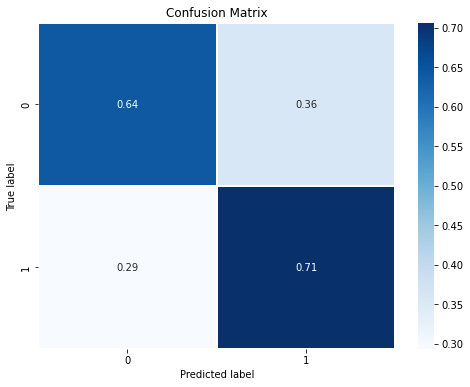

model
Train roc auc 0.9433780757345068
Validation roc auc 0.9320371305010086
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    325787
           1       0.12      0.94      0.21     10622

    accuracy                           0.78    336409
   macro avg       0.56      0.86      0.54    336409
weighted avg       0.97      0.78      0.85    336409



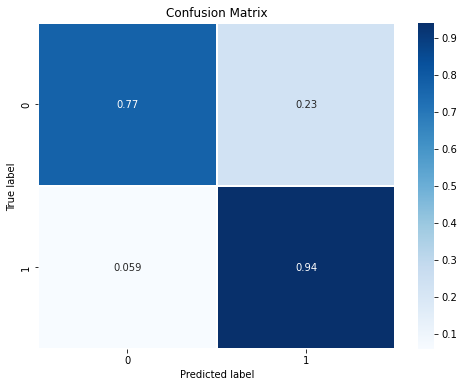

model
Train roc auc 0.7910037401016219
Validation roc auc 0.7756945257612569
              precision    recall  f1-score   support

           0       0.82      0.74      0.78    230006
           1       0.54      0.66      0.59    106403

    accuracy                           0.71    336409
   macro avg       0.68      0.70      0.69    336409
weighted avg       0.73      0.71      0.72    336409



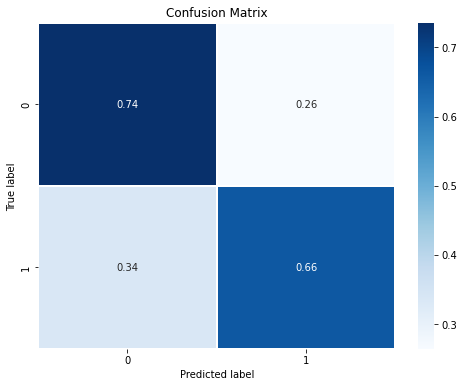

model
Train roc auc 0.8118251318658605
Validation roc auc 0.7965809785550848
              precision    recall  f1-score   support

           0       0.90      0.65      0.75    252844
           1       0.42      0.78      0.55     83565

    accuracy                           0.68    336409
   macro avg       0.66      0.71      0.65    336409
weighted avg       0.78      0.68      0.70    336409



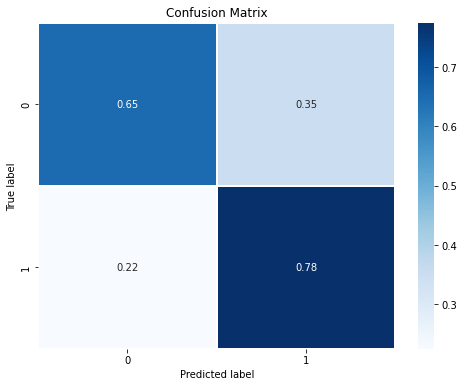

model
Train roc auc 0.8307481863549091
Validation roc auc 0.8227345127832828
              precision    recall  f1-score   support

           0       0.86      0.66      0.74    207503
           1       0.60      0.82      0.69    128906

    accuracy                           0.72    336409
   macro avg       0.73      0.74      0.72    336409
weighted avg       0.76      0.72      0.72    336409



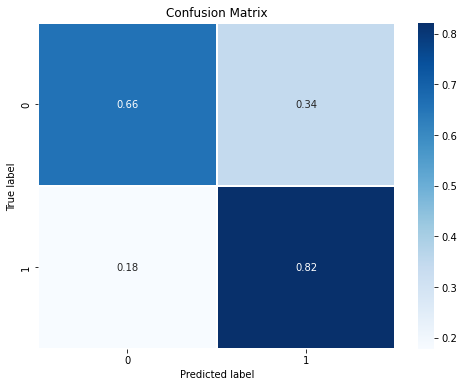

In [ ]:
for targ in target_names:

    validate_model(models[targ], X_train, y_train[targ], X_valid, y_valid[targ])

In [ ]:
X_train.head()

,gamecategory,subgamecategory,bundle,oblast,city,os,osv,loc_weekday_tag,loc_is_weekend_tag,loc_is_academic_year_tag,loc_time_of_day_tag
43727045,NaN,NaN,COM.COMPUTERLUNCH.EVOLUTION,САНКТ-ПЕТЕРБУРГ,САНКТ-ПЕТЕРБУРГ,ANDROID,81,среда,рабочий_день,каникулы,вечер
5328182,NaN,NaN,COM.IPOSEDON.BRICKSBREAKERBALLS,АЛТАЙСКИЙ КРАЙ,БИЙСК,ANDROID,1,понедельник,рабочий_день,каникулы,утро
31685436,NaN,NaN,COM.CREATIVEJOY.RU.JEWELANCIENTTEMPLE,АСТРАХАНСКАЯ ОБЛАСТЬ,АСТРАХАНЬ,ANDROID,601,воскресенье,выходной,каникулы,раннее_утро
35223798,NaN,NaN,COM.AWARDSMEDIAGROUP.TANKS,АСТРАХАНСКАЯ ОБЛАСТЬ,АСТРАХАНЬ,ANDROID,9,понедельник,рабочий_день,каникулы,день
10550958,NaN,NaN,ZOMBIE.SURVIVAL.CRAFT.Z,САНКТ-ПЕТЕРБУРГ,САНКТ-ПЕТЕРБУРГ,ANDROID,1,вторник,рабочий_день,каникулы,день


In [ ]:
X_train_new = X_train.copy()

In [ ]:
X_train_new.head()

,gamecategory,subgamecategory,bundle,oblast,city,os,osv,loc_weekday_tag,loc_is_weekend_tag,loc_is_academic_year_tag,loc_time_of_day_tag
43727045,NaN,NaN,COM.COMPUTERLUNCH.EVOLUTION,САНКТ-ПЕТЕРБУРГ,САНКТ-ПЕТЕРБУРГ,ANDROID,81,среда,рабочий_день,каникулы,вечер
5328182,NaN,NaN,COM.IPOSEDON.BRICKSBREAKERBALLS,АЛТАЙСКИЙ КРАЙ,БИЙСК,ANDROID,1,понедельник,рабочий_день,каникулы,утро
31685436,NaN,NaN,COM.CREATIVEJOY.RU.JEWELANCIENTTEMPLE,АСТРАХАНСКАЯ ОБЛАСТЬ,АСТРАХАНЬ,ANDROID,601,воскресенье,выходной,каникулы,раннее_утро
35223798,NaN,NaN,COM.AWARDSMEDIAGROUP.TANKS,АСТРАХАНСКАЯ ОБЛАСТЬ,АСТРАХАНЬ,ANDROID,9,понедельник,рабочий_день,каникулы,день
10550958,NaN,NaN,ZOMBIE.SURVIVAL.CRAFT.Z,САНКТ-ПЕТЕРБУРГ,САНКТ-ПЕТЕРБУРГ,ANDROID,1,вторник,рабочий_день,каникулы,день


In [ ]:
X_train_new = X_train.copy()

for col in X_train_new.columns:
    X_train_new[col] = X_train_new[col].astype(object)
    
X_train_new = X_train_new.fillna('')

X_train_new['os_with_version'] = X_train_new['os'] + '_' + X_train_new['osv']
X_train_new.drop(columns=['os', 'osv'], inplace=True)

X_train_new['bundle'] = X_train_new['bundle'].apply(lambda x: ' '.join(str(x).split('.')))

full_description = pd.DataFrame(index=X_train_new.index, dtype=object, columns=['full_description'])

full_description['full_description'] = ''
for i in range(len(X_train_new.columns)):
    full_description['full_description'] += ' ' + X_train_new.iloc[:,i]

full_description['full_description'] = full_description['full_description'].str.strip()